# **Proyek Analisis Data: E-Commerce Public Dataset**
- **Nama:** Lorenza Lennyta Dewi
- **Email:** lorenzald123@gmail.com
- **ID Dicoding:** lorenza_ld

## **Menentukan Pertanyaan Bisnis**

- Apa kategori produk yang paling banyak terjual?
- Bagaimana korelasi antara waktu pengiriman dan skor ulasan pelanggan?
- Negara bagian atau kota mana yang memiliki volume penjualan tertinggi?

## **Import Semua Packages/Library yang Digunakan**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **Data Wrangling**

#### Gathering Data

#### Memuat Dataset

Import dataset dan masukan ke variabel customers_df, geolocation_df ,order_items_df, order_payments_df, order_reviews_df,
orders_df, products_df, product_translation_df,
sellers_df di notebook

In [2]:
customers_df = pd.read_csv('/content/customers_dataset.csv')
geolocation_df = pd.read_csv('/content/geolocation_dataset.csv')
order_items_df = pd.read_csv('/content/order_items_dataset.csv')
order_payments_df = pd.read_csv('/content/order_payments_dataset.csv')
order_reviews_df = pd.read_csv('/content/order_reviews_dataset.csv')
orders_df = pd.read_csv('/content/orders_dataset.csv')
products_df = pd.read_csv('/content/products_dataset.csv')
product_translation_df = pd.read_csv('/content/product_category_name_translation.csv')
sellers_df = pd.read_csv('/content/sellers_dataset.csv')

In [3]:
print(customers_df.head())
print(geolocation_df.head())
print(order_items_df.head())
print(order_payments_df.head())
print(order_reviews_df.head())
print(orders_df.head())
print(products_df.head())
print(product_translation_df.head())
print(sellers_df.head())

                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  
   geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                

**Insight:**
Data sudah selesai terimport ke dalam notebook, dan sudah dapat ditampilkan 5 baris teratas

### Assessing Data

In [4]:
# Fungsi untuk mengecek missing values, duplikasi, dan deskripsi data
def check_data(df, df_name):
    print(f"===== {df_name} =====")

    # Deskripsi umum
    print("\nDeskripsi data:")
    print(df.describe(include='all'))

    # Cek missing values
    print("\nMissing values:")
    print(df.isnull().sum())

    # Cek data duplikat
    print("\nJumlah duplikasi:")
    print(df.duplicated().sum())

    # Cek data outlier berdasarkan nilai deskriptif untuk kolom numerik
    numeric_cols = df.select_dtypes(include=['number']).columns

    if len(numeric_cols) > 0:
        print("\nPotensi outliers (berdasarkan IQR):")
        Q1 = df[numeric_cols].quantile(0.25)
        Q3 = df[numeric_cols].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).sum()
        print(outliers)
    else:
        print("\nTidak ada kolom numerik untuk analisis outlier.")

    print("\n===================================\n")

#### Cek missing value, jumlah duplikasi dan potensi outlier

In [6]:
# Cek untuk setiap DataFrame
check_data(customers_df, 'Customers Dataset')
check_data(geolocation_df, 'Geolocation Dataset')
check_data(order_items_df, 'Order Items Dataset')
check_data(order_payments_df, 'Order Payments Dataset')
check_data(order_reviews_df, 'Order Reviews Dataset')
check_data(orders_df, 'Orders Dataset')
check_data(products_df, 'Products Dataset')
check_data(product_translation_df, 'Product Translation Dataset')
check_data(sellers_df, 'Sellers Dataset')

===== Customers Dataset =====

Deskripsi data:
                             customer_id                customer_unique_id  \
count                              99441                             99441   
unique                             99441                             96096   
top     06b8999e2fba1a1fbc88172c00ba8bc7  8d50f5eadf50201ccdcedfb9e2ac8455   
freq                                   1                                17   
mean                                 NaN                               NaN   
std                                  NaN                               NaN   
min                                  NaN                               NaN   
25%                                  NaN                               NaN   
50%                                  NaN                               NaN   
75%                                  NaN                               NaN   
max                                  NaN                               NaN   

        customer

Terlihat beberapa dataset memiliki duplikasi data dan missing value, namun pada tahap selanjutnya hanya beberapa dataset yang digunakan kemudian dilakukan pembersihan.

### Cleaning Data

1. Menggabungkan data produk dengan kategori produk yang diterjemahkan

In [7]:
products_df = pd.merge(products_df, product_translation_df, on='product_category_name', how='left')

2. Mengonversi kolom tanggal pada order menjadi tipe datetime

In [8]:
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df['order_delivered_customer_date'] = pd.to_datetime(orders_df['order_delivered_customer_date'])
orders_df['order_estimated_delivery_date'] = pd.to_datetime(orders_df['order_estimated_delivery_date'])

3. Mengatasi missing values - Hapus baris dengan tanggal pengiriman yang kosong

In [9]:
orders_clean_df = orders_df.dropna(subset=['order_delivered_customer_date', 'order_estimated_delivery_date'])


4. Menambahkan kolom waktu pengiriman (dalam hari)

In [10]:
orders_clean_df.loc[:, 'delivery_time'] = (orders_clean_df['order_delivered_customer_date'] - orders_clean_df['order_purchase_timestamp']).dt.days


<ipython-input-10-5bc01030fcd9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_clean_df.loc[:, 'delivery_time'] = (orders_clean_df['order_delivered_customer_date'] - orders_clean_df['order_purchase_timestamp']).dt.days


5. Menambahkan kolom keterlambatan pengiriman

In [11]:
orders_clean_df.loc[:, 'delivery_delay'] = (orders_clean_df['order_delivered_customer_date'] > orders_clean_df['order_estimated_delivery_date']).astype(int)


<ipython-input-11-527b60d1787c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_clean_df.loc[:, 'delivery_delay'] = (orders_clean_df['order_delivered_customer_date'] > orders_clean_df['order_estimated_delivery_date']).astype(int)


6. Menggabungkan data ulasan dengan data pesanan dan pelanggan

In [12]:
order_reviews_clean_df = pd.merge(order_reviews_df, orders_clean_df[['order_id', 'customer_id', 'delivery_time']], on='order_id', how='left')


7. Menggabungkan item pesanan dengan produk untuk mendapatkan kategori produk

In [13]:
order_items_products_df = pd.merge(order_items_df, products_df[['product_id', 'product_category_name_english']], on='product_id', how='left')


8. Menggabungkan item pesanan dengan pesanan untuk analisis geografis

In [14]:
orders_items_geo_df = pd.merge(order_items_products_df, orders_clean_df[['order_id', 'customer_id']], on='order_id', how='left')
orders_items_geo_df = pd.merge(orders_items_geo_df, customers_df[['customer_id', 'customer_city', 'customer_state']], on='customer_id', how='left')


9. Menampilkan data hasil pembersihan

In [15]:
print(orders_clean_df.head())
print(order_reviews_clean_df.head())
print(orders_items_geo_df.head())

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08

**Insight:**
- Data sudah bersih dan sudah siap untuk dilakukan analisis lebih lanjut

## **Exploratory Data Analysis (EDA)**

#### Deskripsi dataset

In [19]:
print(customers_df.describe())
print(geolocation_df.describe())
print(order_items_df.describe())
print(order_payments_df.describe())
print(order_reviews_df.describe())
print(orders_df.describe())
print(products_df.describe())
print(product_translation_df.describe())
print(sellers_df.describe())

       customer_zip_code_prefix
count              99441.000000
mean               35137.474583
std                29797.938996
min                 1003.000000
25%                11347.000000
50%                24416.000000
75%                58900.000000
max                99990.000000
       geolocation_zip_code_prefix  geolocation_lat  geolocation_lng
count                 1.000163e+06     1.000163e+06     1.000163e+06
mean                  3.657417e+04    -2.117615e+01    -4.639054e+01
std                   3.054934e+04     5.715866e+00     4.269748e+00
min                   1.001000e+03    -3.660537e+01    -1.014668e+02
25%                   1.107500e+04    -2.360355e+01    -4.857317e+01
50%                   2.653000e+04    -2.291938e+01    -4.663788e+01
75%                   6.350400e+04    -1.997962e+01    -4.376771e+01
max                   9.999000e+04     4.506593e+01     1.211054e+02
       order_item_id          price  freight_value
count  112650.000000  112650.000000  112

**Insight:**
- Dari fungsi describe() maka tampil output statistik deskriptif semua dataset. berupa count, mean, std, min, Q1, Q2, Q3, dan nilai max

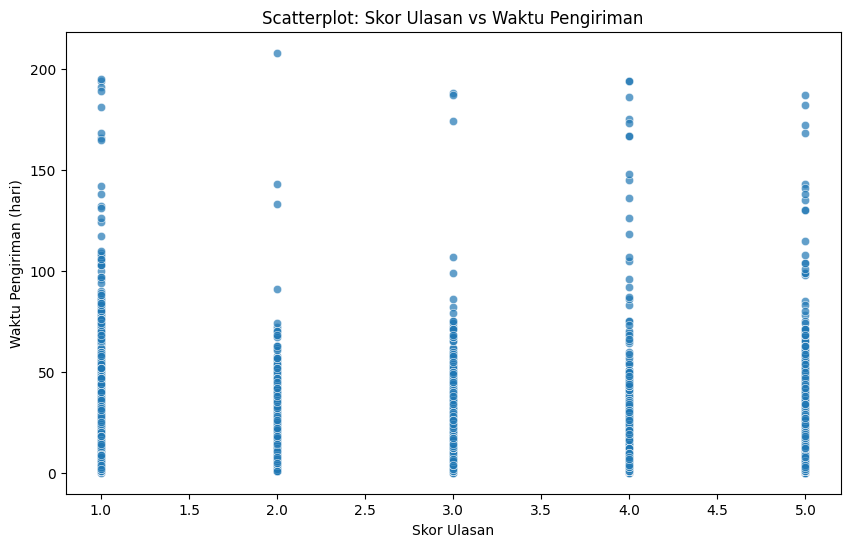

In [25]:
# Scatterplot antara 'review_score' dan 'delivery_time'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_score', y='delivery_time', data=order_reviews_clean_df, alpha=0.7)
plt.title('Scatterplot: Skor Ulasan vs Waktu Pengiriman')
plt.xlabel('Skor Ulasan')
plt.ylabel('Waktu Pengiriman (hari)')
plt.show()

Secara keseluruhan, data ini tidak menunjukkan adanya korelasi linear yang kuat antara kedua variabel.

## **Visualization & Explanatory Analysis**

- Apa kategori produk yang paling banyak terjual?
- Bagaimana korelasi antara waktu pengiriman dan skor ulasan pelanggan?
- Negara bagian atau kota mana yang memiliki volume penjualan tertinggi?

### Pertanyaan 1 : Apa kategori produk yang paling banyak terjual?

Visualisasi kategori produk yang paling banyak terjual

<ipython-input-16-39ef0c8b8691>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_sales.values, y=category_sales.index, palette="viridis")
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When groupi

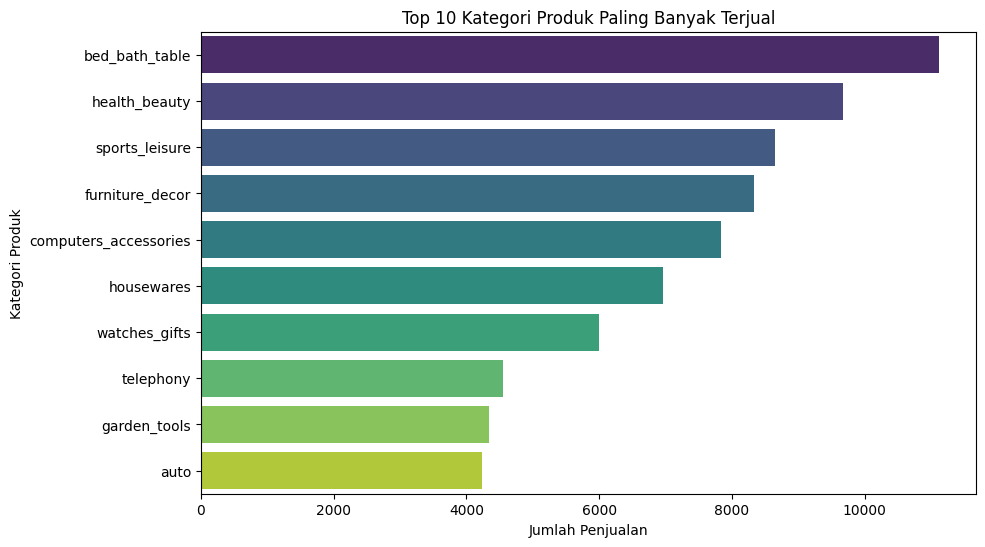

In [16]:
category_sales = order_items_products_df['product_category_name_english'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=category_sales.values, y=category_sales.index, palette="viridis")
plt.title('Top 10 Kategori Produk Paling Banyak Terjual')
plt.xlabel('Jumlah Penjualan')
plt.ylabel('Kategori Produk')
plt.show()

### Pertanyaan 2 : Bagaimana korelasi antara waktu pengiriman dan skor ulasan pelanggan?

Visualisasi korelasi antara review score dan waktu pengiriman

<ipython-input-17-1e1a489cb854>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='review_score', y='delivery_time', data=order_reviews_clean_df, palette="coolwarm")
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a

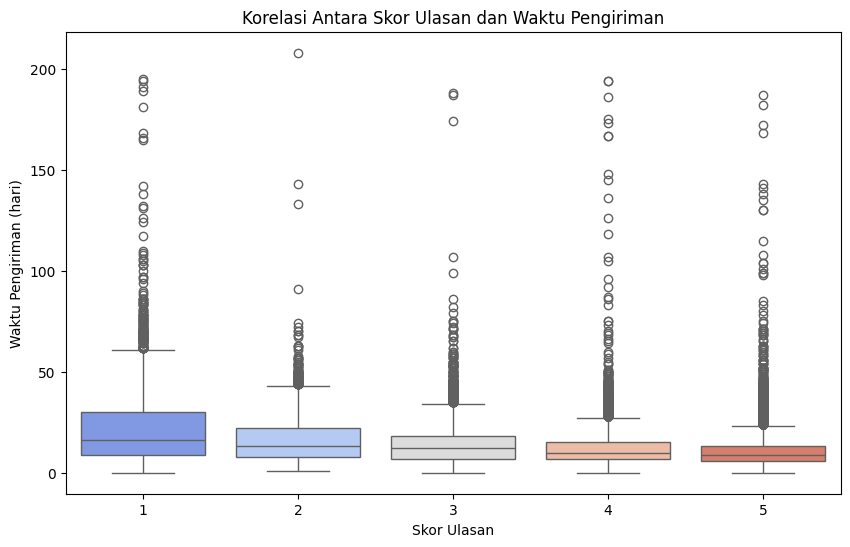

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_score', y='delivery_time', data=order_reviews_clean_df, palette="coolwarm")
plt.title('Korelasi Antara Skor Ulasan dan Waktu Pengiriman')
plt.xlabel('Skor Ulasan')
plt.ylabel('Waktu Pengiriman (hari)')
plt.show()

### Pertanyaan 3 : Negara bagian atau kota mana yang memiliki volume penjualan tertinggi?

Visualisasi jumlah penjualan berdasarkan negara bagian

<ipython-input-18-45dc08410d67>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_sales.index, y=state_sales.values, palette="Set2")
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a

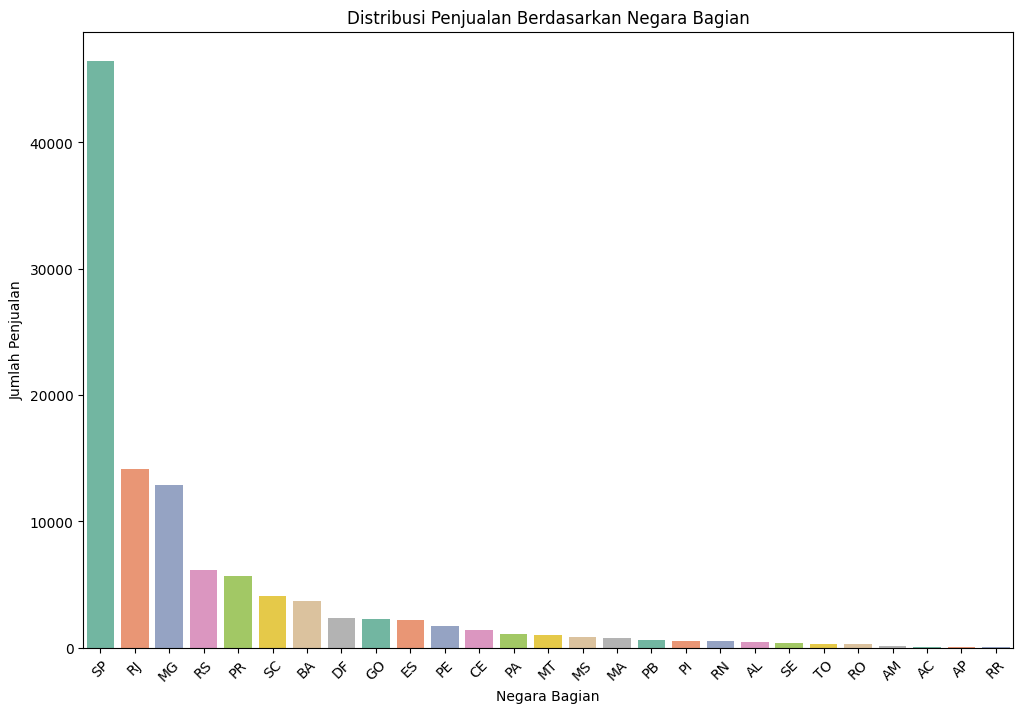

In [18]:
state_sales = orders_items_geo_df['customer_state'].value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x=state_sales.index, y=state_sales.values, palette="Set2")
plt.title('Distribusi Penjualan Berdasarkan Negara Bagian')
plt.xlabel('Negara Bagian')
plt.ylabel('Jumlah Penjualan')
plt.xticks(rotation=45)
plt.show()

### **Conclusion**

- Berdasarkan Kategori Produk Paling Banyak Terjual adalah bed_bath_table dan paling sedikit adalah auto
- Dari grafik, terlihat bahwa semakin rendah skor ulasan (1 dan 2), waktu pengiriman cenderung lebih lama, dengan median yang lebih tinggi. Sebaliknya, skor ulasan yang lebih tinggi (4 dan 5) memiliki waktu pengiriman yang lebih cepat. Ini menunjukkan bahwa pengiriman yang lebih lama dapat berkontribusi terhadap ulasan yang buruk.
- Grafik menunjukkan bahwa penjualan e-commerce sangat didominasi oleh São Paulo (SP), dengan jumlah penjualan jauh lebih tinggi dibandingkan negara bagian lainnya. Rio de Janeiro (RJ) dan Minas Gerais (MG) berada di posisi kedua dan ketiga, namun dengan angka penjualan yang jauh lebih rendah. Sebagian besar negara bagian lainnya memiliki kontribusi penjualan yang kecil.

### **Data untuk dashboard**

In [27]:
# Menggabungkan order_items_products_df dan order_reviews_clean_df berdasarkan ID yang relevan
main_data = order_items_products_df.merge(order_reviews_clean_df, on='order_id', how='left')

# Menyimpan data akhir ke file CSV
main_data.to_csv('/content/main_data.csv', index=False)